<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; padding: 30px 30px 0px 30px;">Design an application for public health - Project 3</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;">
    <span style="width: 100%; text-align: center; font-size:20px; font-weight: bold; float: left;">| Cleaning notebook |</span>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <span style="width: 100%; text-align: center; font-size:26px; float: left;">Data Scientist course - OpenClassrooms</span>
</div>

<div class="alert alert-block alert-info">
    This <b>notebook</b> is optimized to <b>be used</b> with:
    <ul style="list-style-type: square;">
    <li>JupyterLab 3.0.14</li>
    <li>JupyterLab Theme: JupyterLab Dark</li>
    <li>Extension: @jupyter-widgets/jupyterlab-manager</li>
</ul>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
import os
import io
import gc
from math import prod
import time as time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


%matplotlib inline

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [2]:
def df_analysis(df, name_df, columns, *args, **kwargs):
    """
    Class used for analyzing on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        columns (list): Dataframe keys in list format
        
        *args, **kwargs:
        -----------------
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    flag = kwargs.get("flag", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
            print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        pd.set_option("display.max_rows", None) # show full of showing rows
        pd.set_option("display.max_columns", None) # show full of showing cols
        pd.set_option("max_colwidth", None) # show full width of showing cols
        
        if flag is None or flag != "complete":
            print("\n- Type object and records by columns   (",memory_usage,")")
            print("--------------------------------------------------------------------")
        elif flag == "complete":
            df_resume["unique"] = list(df.nunique())
            df_desc = pd.DataFrame(df.describe().T).reset_index()
            df_desc = df_desc.rename(columns={"index": "name"})
            df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
            df_resume = df_resume[ORDERING_COMPLETE]
            print("\n- Type object and records by columns                                                                        (",memory_usage,")")
            print("---------------------------------------------------------------------------------------------------------------------------------------")
        
        display(df_resume.sort_values("records", ascending=False))
        
        pd.reset_option("display.max_rows") # reset max of showing rows
        pd.reset_option("display.max_columns") # reset max of showing cols
        pd.reset_option("display.max_colwidth") # reset width of showing cols
        
        # deleting dataframe to free memory
        if flag == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()
            
               
def plot_values_missingno(df, first_col, last_col, *args, **kwargs):
    """
    Plotting missing values with missingno

    Parameters
    -----------------
        df (pandas.DataFrame): Dataset to analyze.
        first_col (int): First column to graph.
        last_col (int): Last column to graph.
        numbers_plot (int): Total numbers of graphs.
        plot_number (int): Number of the graph.
        
    Returns:
    -----------------
        None. 
        Plotting the missing values with missingno
    """
    
    # Getting the variables
    numbers_plot = kwargs.get("numbers_plot", None)
    plot_number = kwargs.get("plot_number", None)
    
    
    fig, axs = plt.subplots(2,1)
    msno.matrix(df.iloc[:, first_col:last_col], sparkline=False, fontsize=14, ax=axs[0])
    msno.bar(df.iloc[:, first_col:last_col], ax=axs[1], fontsize=14)            

    for ax in axs:
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [s[:8] + "..." + s[-8:] if len(s) > 16 else s for s in labels]
        ax.axes.set_xticklabels(short_labels)

    fig.set_size_inches(18,14)
    [ax.grid() for ax in axs.flatten()];
    [sns.despine(ax=ax, right=False, left=False, top=False, bottom=False) for ax in axs.flatten()];

    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    
    if plot_number == None:
        fig.suptitle("Missing data overview", fontweight="bold", fontsize=20)
    else:
        fig.suptitle("Missing data overview\n(part " + str(plot_number) + "/" + str(numbers_plot) + ")", fontweight="bold", fontsize=20)       

    plt.show()
                        
            
def plot_missing_values(df, numbers_col):
    """
    Method used for plotting missing values

    Parameters
    -----------------
        df (pandas.DataFrame): Dataset to analyze.
        numbers_col (int): Number of columns to show in each image.
        
    Returns:
    -----------------
        None. 
    """
    
    first_col = 0
    
    if df.shape[1] // numbers_col != 0:
        
        for i in range (1, df.shape[1] // numbers_col + 1):
            
            if i == df.shape[1] // numbers_col:
                last_col = None
            else:
                last_col = i * numbers_col

            plot_values_missingno(df, first_col, last_col, numbers_plot=(df.shape[1] // numbers_col), plot_number=i)

            if i == data.shape[1] // 30:
                # deleting dataframe to free memory
                del [df]
                gc.collect()
                df = pd.DataFrame()

                break            
            else:
                first_col = last_col + 1
    else:
        
        plot_values_missingno(df, first_col, None)
            
        del [df]
        gc.collect()
        df = pd.DataFrame()
            
            
class GroupImputer(BaseEstimator, TransformerMixin):
    """ 
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters:
    -----------------  
        group_cols (list) : List of columns used for calculating the aggregated value 
        strategy (str) : The strategy to be used for remplacement, can be one of ["mean", "median", "mode"]
        
    Returns:
    -----------------
        X (array-like) : The array with imputed values in the target column
   """
   
    def __init__(self, group_cols, strategy):
        
        assert strategy in ["mean", "median", "mode"], "Unrecognized value for metric, should be mean/median/mode"
        assert type(group_cols) == list, "group_cols should be a list of columns"
        
        self.group_cols = group_cols
        self.strategy = strategy
    
    def fit(self, X, y=None):
        
        # replacing NaN with "-1" in group_cols to assign the mean of all target without group_cols
        for col in self.group_cols:
            X[col].fillna(-1, inplace=True)
            
        for col in X.columns:
            if X[col].dtypes == "float32":
                impute_map[col] = X.groupby(self.group_cols)[col].agg(self.strategy).reset_index(drop=False)
        
        # reset values par defaut
        for col in self.group_cols:
            X[col].replace(-1, np.nan, inplace=True)
        
        self.impute_map_ = impute_map
        
        return self    

    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy()
        
        for col in X.columns:
            if X[col].dtypes == "float32":
                for index, row in self.impute_map_.iterrows():
                    ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
                    X.loc[ind, col] = X.loc[ind, col].fillna(row[col])
                
        return X.values 

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

<div class="alert alert-block alert-info">
Reading data in <b>chunks of 1 million rows</b> at a time
</div>

In [3]:
start = time.time()
chunk = pd.read_csv("datasets/en.openfoodfacts.org.products.csv", chunksize=1000000, sep="\t", encoding="UTF-8")
data = pd.concat(chunk)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")

C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,27,28,29,31,47,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,29,31,47,52,64,81,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Read csv with chunks:  71.10651636123657 sec


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Missing data overview</h3>
</div>

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

<div class="alert alert-block alert-warning">
    Based on the function <b>df_analysis</b> we got the following facts:
    <ul style="list-style-type: square;">
        <li>Almost <b>80%</b> of the data present in data set are <b>missing values</b></li>
        <li>There are <b>5 empty columns</b> that we can delete</li>
        <li>There is a lot of <b>memory usage</b> with this dataset</li>
    </ul>
</div>

In [4]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760097 rows and 186 columns
- Total of NaN values:            260478039
- Percentage of NaN:              79.56 %
- Total of full duplicates rows:  1
- Total of empty rows:            0
- Total of empty columns:         5
  + The empty column are:          ['cities', 'allergens_en', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil']
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 2.4+ GB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,1760097,0,0.00
6,last_modified_datetime,object,1760097,0,0.00
63,states_en,object,1760097,0,0.00
62,states_tags,object,1760097,0,0.00
61,states,object,1760097,0,0.00
1,url,object,1760097,0,0.00
5,last_modified_t,int64,1760097,0,0.00
4,created_datetime,object,1760097,0,0.00
3,created_t,int64,1760097,0,0.00
2,creator,object,1760093,4,0.00


<div class="alert alert-block alert-info">
Plotting missing values with <b>missingno</b>
</div>

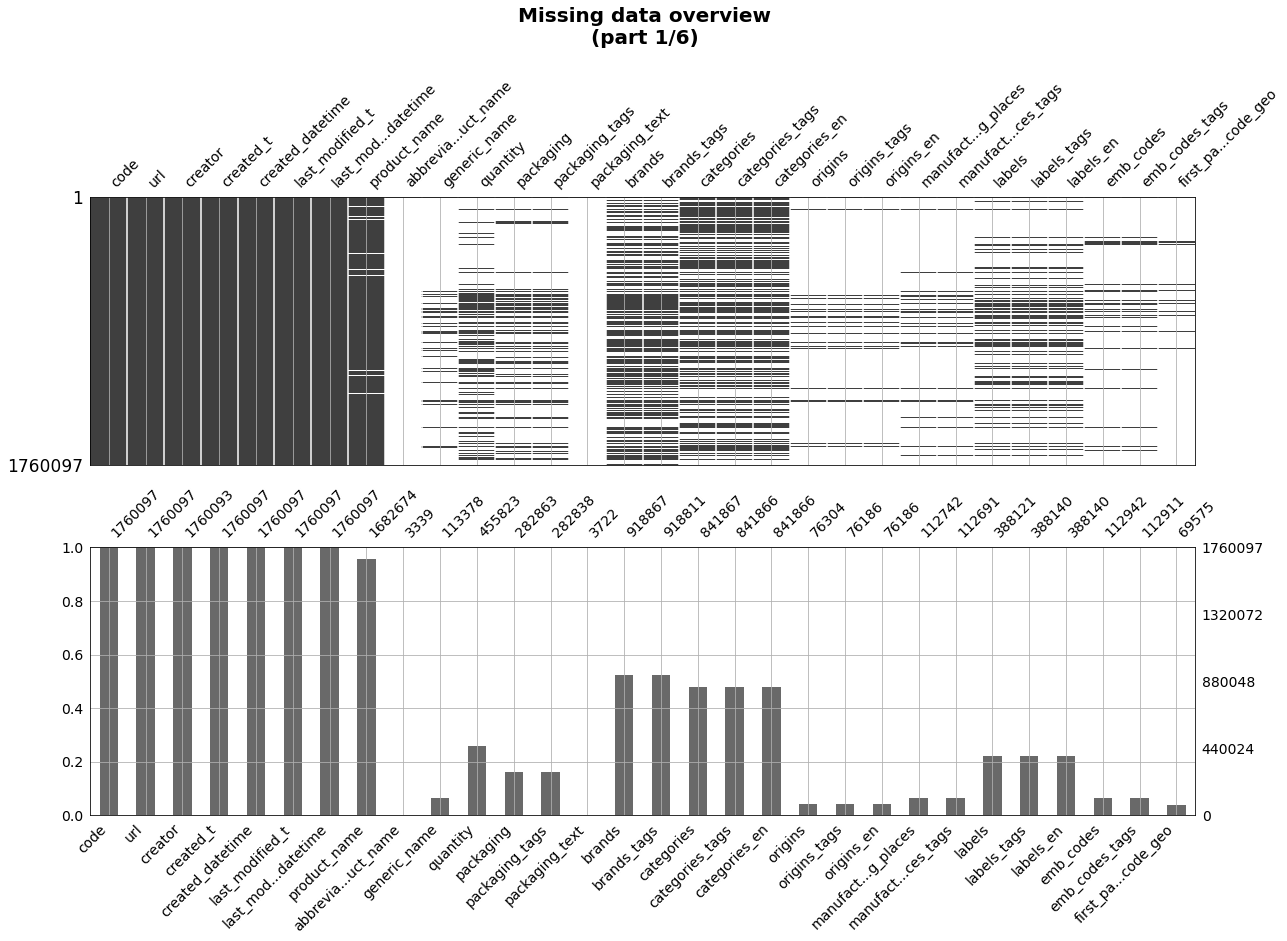

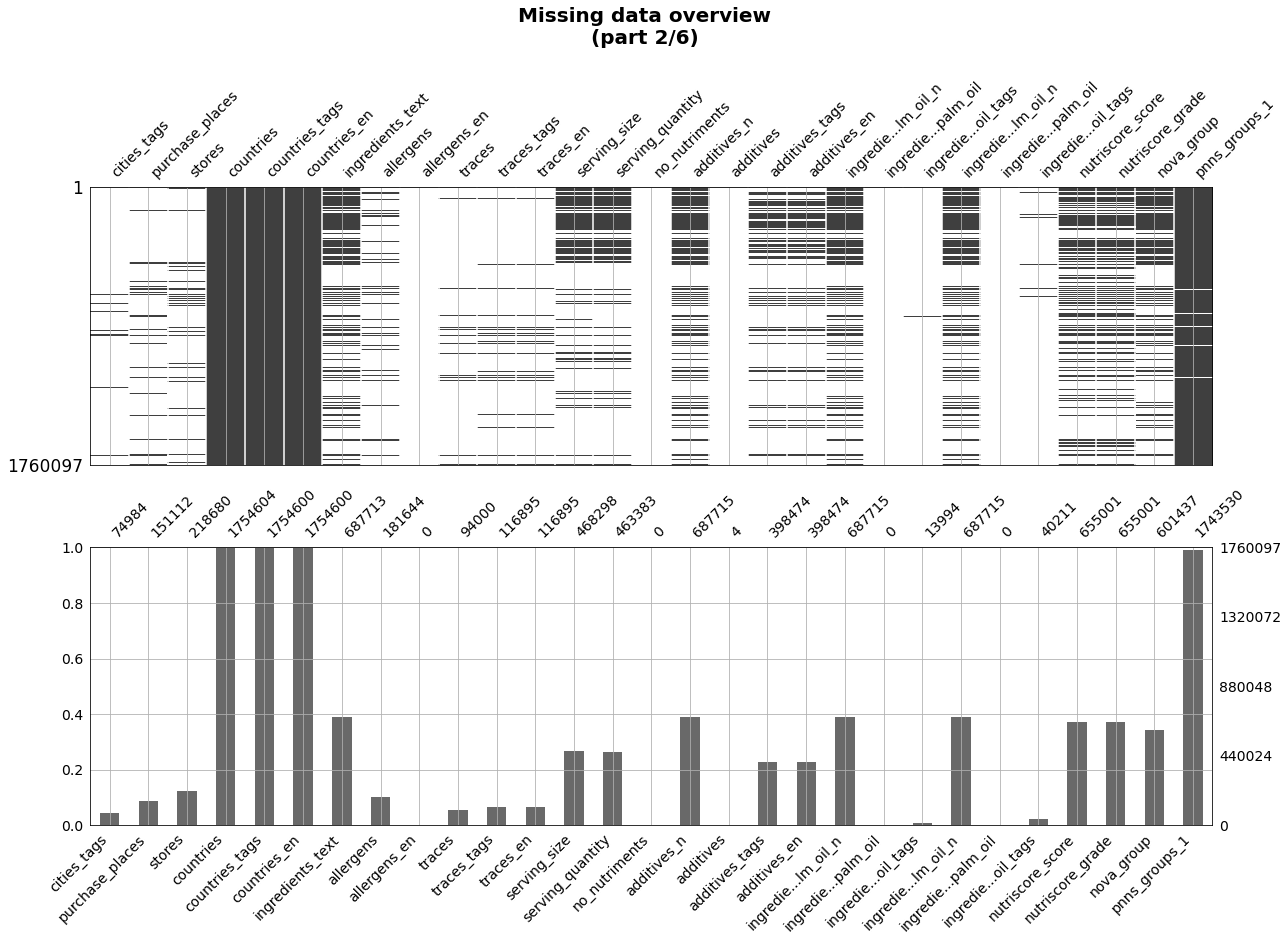

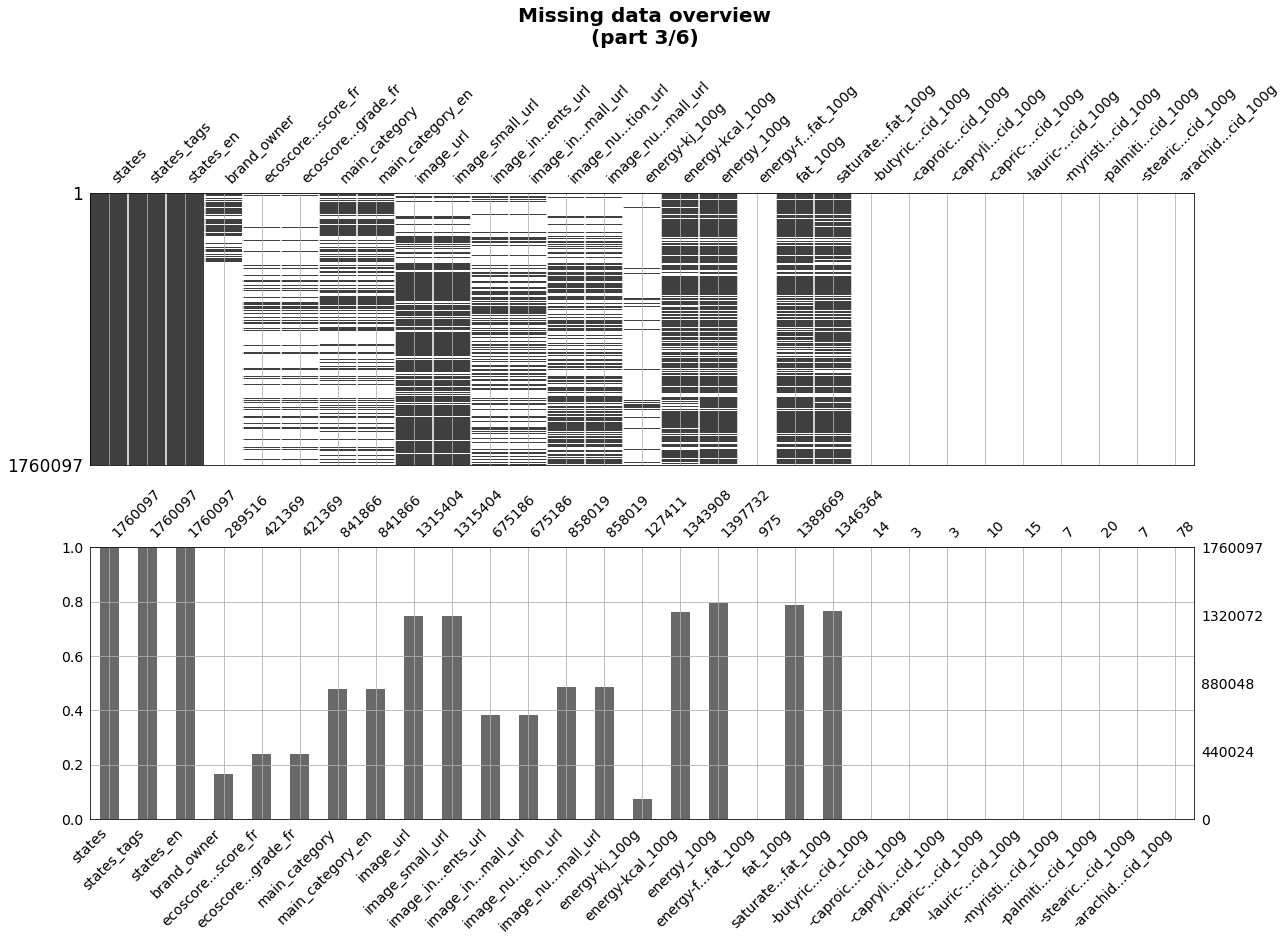

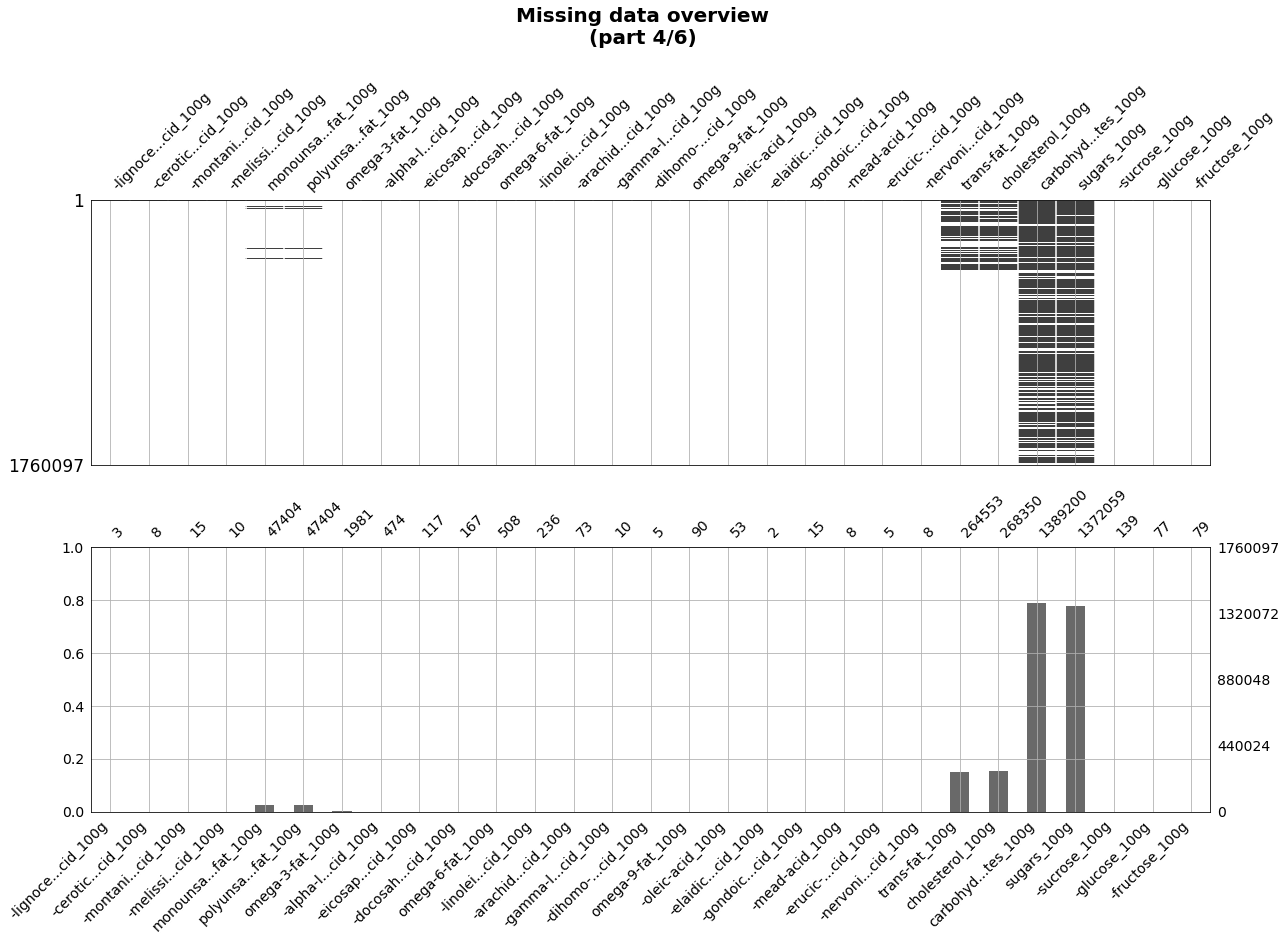

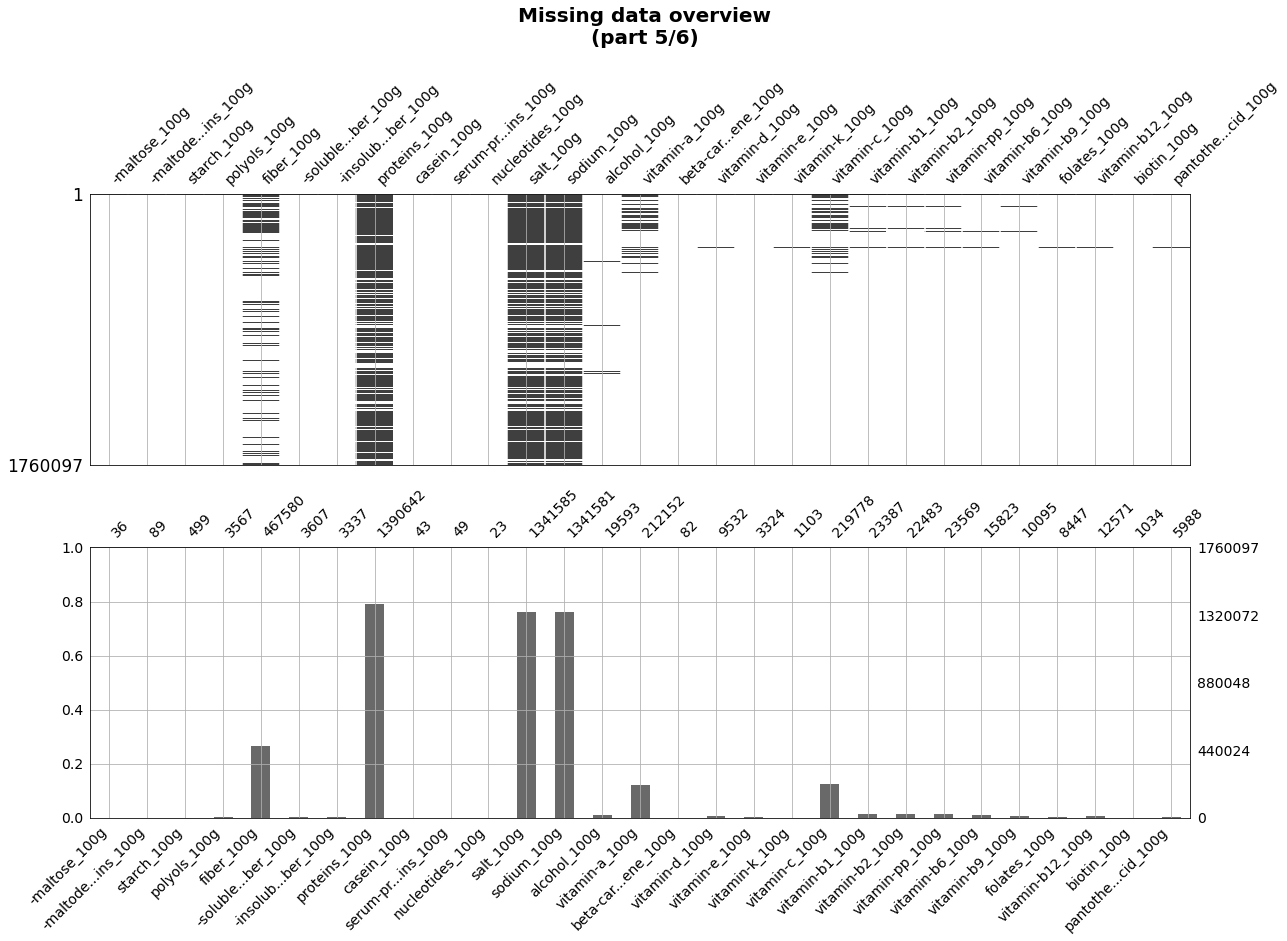

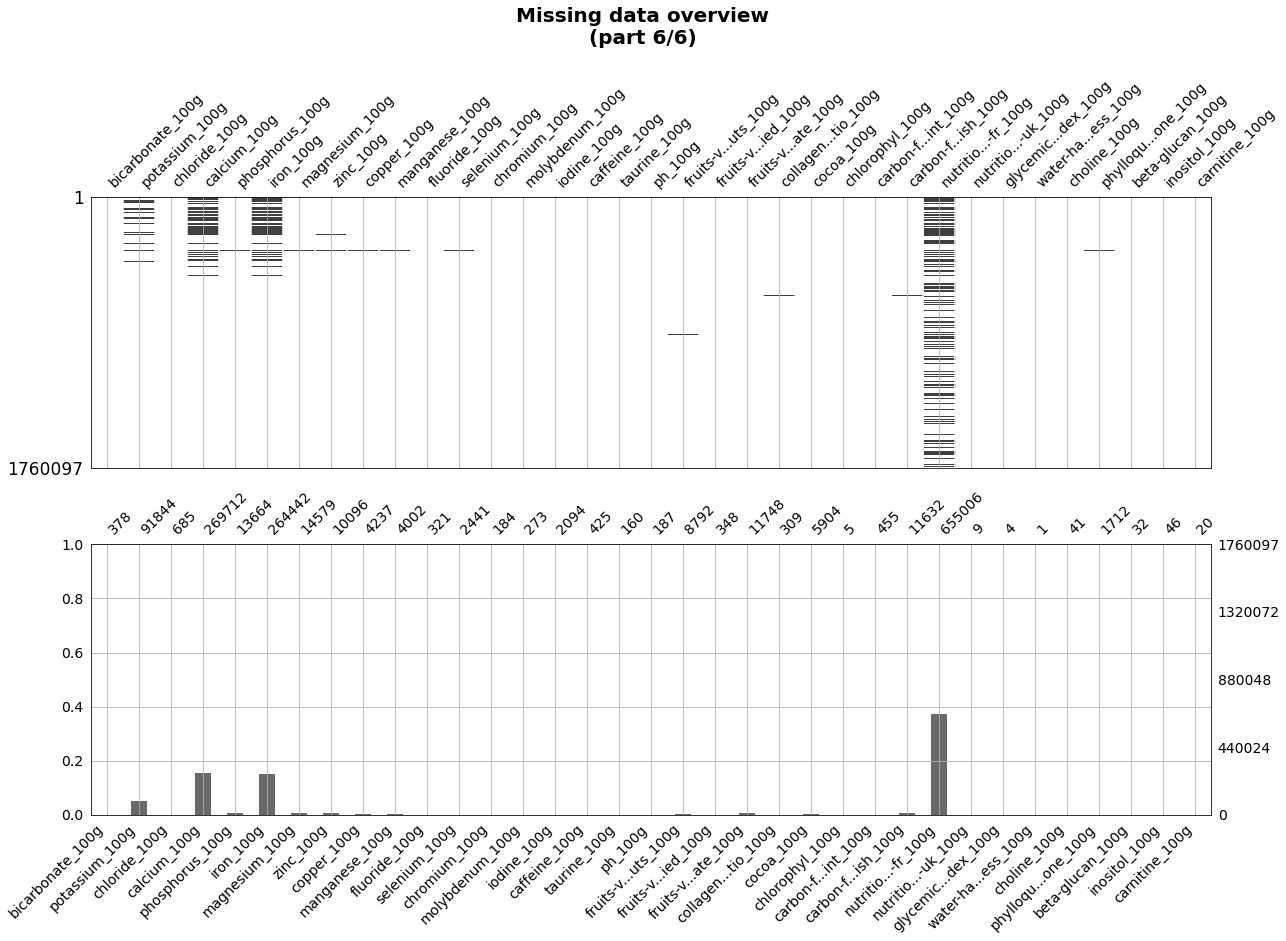

In [5]:
plot_missing_values(data, 30)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Initial cleaning</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Deleting NaN columns and rows, and duplicated rows</h3>
</div>

In [6]:
data = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

In [7]:
data = data.drop_duplicates()

In [8]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760096 rows and 181 columns
- Total of NaN values:            251677390
- Percentage of NaN:              79.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 2.4+ GB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,1760096,0,0.00
58,states_en,object,1760096,0,0.00
3,created_t,int64,1760096,0,0.00
4,created_datetime,object,1760096,0,0.00
5,last_modified_t,int64,1760096,0,0.00
6,last_modified_datetime,object,1760096,0,0.00
57,states_tags,object,1760096,0,0.00
1,url,object,1760096,0,0.00
56,states,object,1760096,0,0.00
2,creator,object,1760092,4,0.00


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Fixing the columns types</h3>
</div>

<div class="alert alert-block alert-warning">
There are some columns with column type wrong. We can see this information based on:
<ul style="list-style-type: square;">
    <li>Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b></li>
    <li>At the momento to <b>import the *.csv</b></li>
    <li>As a result of the function <b>df_initial_analysis</b></li>
</ul>

Due to that, we are going to proceed to fix them. 
</div>
<div class="alert alert-block alert-info">
<b>Fixing column types float64</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li>fields that end with <b>_100g</b> correspond to <b>the amount of a nutriment</b> (in g, or kJ for energy) for <b>100 g</b> or <b>100 ml</b> of product</li>
    <li>fields that end with <b>_serving</b> correspond to <b>the amount of a nutriment</b> (in g, or kJ for energy) for <b>1</b> serving of the product</li>
</ul>

Finally, we are going to make the <b>downcast</b> from <b>float64</b> to <b>float32</b> 
</div>

In [9]:
for col in data.columns:
    if (col.endswith("_100g") or col.endswith("_serving")) and data[col].dtypes != "float64":
        print("Column to update the column type:", col, data[col].dtypes)
        data[col] = data[col].astype("float64")

Column to update the column type: -butyric-acid_100g object
Column to update the column type: -capric-acid_100g object


In [10]:
for col in data.columns:
    if data[col].dtypes == "float64":
        data[col] = data[col].astype("float32")

<div class="alert alert-block alert-info">
<b>Fixing column types datetime</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following:
<ul style="list-style-type: square;">
    <li>fields that end with <b>_t</b> are dates in <b>the UNIX timestamp format</b> (number of seconds since Jan 1st 1970)</b></li>
    <li>fields that end with <b>_datetime</b> are dates in <b>the iso8601 format: yyyy-mm-ddThh:mn:ssZ</b></li>
</ul>

In this case, both group of columns have the same amount of data. Due to that, we will only keep the columns ended by <b>_datetime</b>
</div>

In [11]:
for col in data.columns:
    if col.endswith("_datetime") and data[col].dtypes != "datetime64":
        print("Column to update the column type:", col, data[col].dtypes)
        data[col] = data[col].astype("datetime64")

Column to update the column type: created_datetime object
Column to update the column type: last_modified_datetime object


In [12]:
for col in data.columns:
    if col.endswith("_t"):
        print("Column to delete:", col, data[col].dtypes)
        data = data.drop(col, axis=1)  

Column to delete: created_t int64
Column to delete: last_modified_t int64


<div class="alert alert-block alert-info">
Checking the usage of memory
</div>

In [13]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760096 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: datetime64[ns](2), float32(118), object(59)
memory usage: 8.1 GB


<div class="alert alert-block alert-info">
If the number of unique values in a specific column is less than the half numbers of rows in the same column,<br>
we are going to change the type from <b>object</b> to <b>category</b> to improve the usage of memory
</div>

In [14]:
for col in data.columns:
    if data[col].dtypes == "object":
        if len(data[col].unique()) / len(data[col]) < 0.5:
            data[col] = data[col].astype("category")
        else:
            data[col] = data[col].astype("object")

<div class="alert alert-block alert-info">
Checking the usage of memory
</div>

In [15]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760096 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: category(54), datetime64[ns](2), float32(118), object(5)
memory usage: 2.9 GB


In [16]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760096 rows and 179 columns
- Total of NaN values:            251677390
- Percentage of NaN:              79.88 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 1.4+ GB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,1760096,0,0.00
54,states,category,1760096,0,0.00
56,states_en,category,1760096,0,0.00
55,states_tags,category,1760096,0,0.00
1,url,object,1760096,0,0.00
4,last_modified_datetime,datetime64[ns],1760096,0,0.00
3,created_datetime,datetime64[ns],1760096,0,0.00
2,creator,category,1760092,4,0.00
53,pnns_groups_2,category,1759729,367,0.02
31,countries,category,1754603,5493,0.31


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Filtering information</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Filtering information by country France</h3>
</div>

<div class="alert alert-block alert-info">
<b>Countries where the product is sold</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li> There are three fields about countries where the product is sold</li>
        <ul style="list-style-type: disc;">
            <li>countries</li>
            <li>countries_en</li>
            <li>countries_tags</li>
        </ul>
</ul>

After analyzing the columns, we have decided to used the columns called <b>countries</b>.<br>
We are going to filter considering only France and its overseas department
</div>

In [17]:
FILTERING_BY_FRANCE = [
    "France", "fr", "Francia", "French", "Frankreich", "Nouvelle-Calédonie", "Martinique", "Guadeloupe", "Polynésie Française", "Mayotte"
]

<div class="alert alert-block alert-success">
At this point, we have reduced the amount of data in the dataset filtering by country France
</div>

In [18]:
data = pd.DataFrame(data[data["countries"].str.contains("|".join(FILTERING_BY_FRANCE), case = False, na=False).any(level=0)])

In [19]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798009 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: category(54), datetime64[ns](2), float32(118), object(5)
memory usage: 1.8 GB


In [20]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  798009 rows and 179 columns
- Total of NaN values:            114437088
- Percentage of NaN:              80.11 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         4
  + The empty column are:          ['-lignoceric-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-elaidic-acid_100g', 'water-hardness_100g']
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 710.3+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,798009,0,0.00
54,states,category,798009,0,0.00
3,created_datetime,datetime64[ns],798009,0,0.00
4,last_modified_datetime,datetime64[ns],798009,0,0.00
55,states_tags,category,798009,0,0.00
56,states_en,category,798009,0,0.00
1,url,object,798009,0,0.00
33,countries_en,category,798009,0,0.00
32,countries_tags,category,798009,0,0.00
31,countries,category,798009,0,0.00


In [21]:
data = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

<div class="alert alert-block alert-info">
Exectuting the <b>describe()</b> function on the dataframe
</div>

In [22]:
pd.set_option("display.max_columns", None) # show full of showing cols
data.describe()

C:\Users\Samir\anaconda3\lib\site-packages\numpy\lib\function_base.py:3964: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t>=0.5)


,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,ecoscore_score_fr,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,79357.000000,243846.000000,243846.000000,243846.000000,278981.000000,204621.000000,255512.000000,7.190500e+04,5.955160e+05,6.230900e+05,131.000000,617113.000000,620073.000000,3.000000e+00,2.000000,1.0,2.000,7.000000,1.00,4.000000e+00,2.000000,29.000000,12.000000,1.0,2.000000,4.000000e+00,3134.000000,3157.000000,1348.000000,340.000000,63.000000,99.000000,292.000000,203.000000,31.000000,4.000000,4.900000e+01,21.000000,3.000000,1.00000,2.000000e+00,2.000000e+00,3647.000000,3677.000000,617058.00000,619338.000000,24.000000,2.900000e+01,53.000000,228.000000,13.000000,57.000000,290.000000,765.000000,139641.000000,188.000000,181.000000,618992.000000,39.000000,31.000000,15.000000,603563.000000,603562.000000,9209.000000,3396.000000,49.000000,1.611000e+03,1785.000000,178.000000,4833.000000,2188.000000,1798.000000,1786.000000,1978.000000,1462.000000,238.000000,1.597000e+03,403.000000,928.000000,77.000000,231.000000,2683.000000,424.000000,8408.000000,1618.000000,5291.000000,2472.000000,930.000000,372.000000,392.000000,1.970000e+02,281.000000,47.000000,45.000000,343.000000,111.000000,57.000000,130.000000,6300.000000,307.000000,10488.000000,296.000000,4409.000000,3.000000,319.000000,11632.000000,278984.000000,5.000000,4.000000,31.000000,29.000000,18.000000,24.000000,14.000000
mean,118.894379,1.615872,0.048883,0.114092,9.532871,3.411380,48.509956,1.103681e+03,2.832928e+02,1.178383e+03,432.374054,14.309522,5.446947,2.582482e+20,24.014999,97.0,inf,27.353390,0.12,1.532558e+00,2.100000,3.947972,1.257143,0.0,31.000000,5.264027e-01,20.867825,9.733136,3.332329,2.166044,2.646438,0.844953,17.107796,3.695531,0.532343,0.823750,4.233134e+01,30.364353,11.001293,0.00057,1.550030e-02,7.000000e+00,0.035219,0.048734,27.36570,13.761168,17.400002,1.302966e+01,29.481323,8.522764,8.162395,5.817037,32.900581,44.481972,3.022539,2.005319,4.316906,9.138214,4.165897,4.316871,0.796109,1.310894,0.524460,6.043071,0.546040,0.869422,1.870809e-01,0.187911,0.001249,0.229725,0.900481,0.05

In [23]:
pd.reset_option("display.max_columns") # reset max of showing cols

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Nutri-Score and App idea fields</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1. Idenfiying Nutri-Score and App idea fields</h3>
</div>

<div class="alert alert-block alert-info">
Based on <b>Santé publique France</b> we can get the fiedls to calculate the <b>Nutri-Score</b><br><br>
You can see the information in details in the link below<br>
<b>https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score</b><br><br>
    
<b>Nutri-Score fields</b>
<ul style="list-style-type: square;">
    <li>Energetic value</li>
    <li>Fat</li>
    <li>Saturated fat</li>
    <li>Sugar</li>
    <li>Protein</li>
    <li>Salt / Sodium</li>
    <li>Fibers</li>
    <li>Fruits, vegetables, legumes, nuts, rapeseed, walnut and olive oils</li>
</ul>
</div>

In [24]:
pd.set_option("display.max_columns", None)
data.head(5)

,code,url,creator,created_datetime,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,traces,traces_tags,traces_en,serving_size,serving_quantity,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,2018-06-15 10:38:00,2019-06-25 11:55:18,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,375.0,1569.0,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.099998,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,1.40,0.560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [25]:
pd.reset_option("display.max_columns")

<div class="alert alert-block alert-info">
After analyzing the columns we can identify the following fields for <b>Nutri-Score</b> <b>and App idea</b> 
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Field</th>
        <th style="font-weight: bold;">Description</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            energy-kj_100g<br>
            energy-kcal_100g<br>
            energy_100g</td>
        <td align="left">
            The fields energy-kj_100g and energy_100g seem to be the same value.<br>
            Consider the measure units to work with the values.
        </td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
        <td align="center">Nutri-score</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
        <td align="left"></td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
        <td align="left"></td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">Salt / Sodium</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            salt_100g<br>
            sodium_100g</td>
        <td align="left">Consider the measure units to work with the values.</td>
 	</tr>
  	<tr>
		<td align="left">Fibers</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">fiber_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            fruits-vegetables-nuts_100g<br>
            fruits-vegetables-nuts-estimate_100g
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
    <tr>
		<td align="left">Code</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">code</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Last modified</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">last_modified_datetime</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Product name</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">product_name</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Category</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">
            categories<br>
            main_category<br>
            main_category_en<br>
            categories_tags<br>
            categories_en
        </td>
        <td align="left">It is necessary to analyze these fields more in details.</td>
 	</tr>
    <tr>
		<td align="left">Brand</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">
            brands<br>
            brands_tags
        </td>
        <td align="left">It is necessary to analyze these fields more in details.</td>
 	</tr>
    <tr>
		<td align="left">Image</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">image_url</td>
        <td align="left"></td>
 	</tr>
</table>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.2. Analyzing  the Nutri-Score and App idea fields</h3>
</div>

<div class="alert alert-block alert-info">
    Let's create a dataframe with interesting fields of <b>Nutri-Score</b> and the <b>application idea</b>
</div>

In [26]:
BASIC_FIELDS = [
    "code", "last_modified_datetime", "product_name", "brands", "brands_tags",
    "categories", "main_category", "main_category_en", "categories_tags", 
    "categories_en", "image_url"
]

In [27]:
NUTRI_SCORE_FIELDS = [
    "energy-kj_100g", "energy-kcal_100g", "energy_100g", "fat_100g", "saturated-fat_100g", 
    "sugars_100g", "proteins_100g", "salt_100g", "sodium_100g", "fiber_100g", 
    "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [28]:
df_nutri_score = data[BASIC_FIELDS + NUTRI_SCORE_FIELDS].copy(deep=True)

<div class="alert alert-block alert-info">
Deleting <b>data</b> dataframe to free memory
</div>

In [29]:
del data
gc.collect()
data = pd.DataFrame()

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

In [30]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  798009 rows and 23 columns
- Total of NaN values:            7489628
- Percentage of NaN:              40.81 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 105.7+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,798009,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],798009,696994,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,775020,528750,22989,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,image_url,object,720228,720158,77781,9.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,energy_100g,float32,623090,4545,174919,21.92,1178.382935,0.0,464.000,1100.000000,1674.000000,12200000.0,15538.601562
15,saturated-fat_100g,float32,620073,3684,177936,22.30,5.446947,0.0,0.200,2.000000,8.000000,21900.0,29.066158
16,sugars_100g,float32,619338,5341,178671,22.39,13.761168,-1.0,0.600,3.500000,19.985256,6880.0,21.925907
17,proteins_100g,float32,618992,4101,179017,22.43,9.138214,0.0,1.500,6.200000,12.900000,173000.0,220.102295
14,fat_100g,float32,617113,4941,180896,22.67,14.309522,0.0,1.000,8.000000,22.000000,91200.0,117.423164
18,salt_100g,float32,603563,6284,194446,24.37,1.310894,0.0,0.060,0.510000,1.300000,25000.0,32.950630


<div class="alert alert-block alert-info">
    Processing the duplicates
</div>

In [31]:
df_nutri_score.drop_duplicates(inplace=True)

In [32]:
df_nutri_score[df_nutri_score["categories"].notnull()].head(5)

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
4,0000000000100,2015-10-12 14:13:32,moutarde au moût de raisin,courte paille,courte-paille,"Epicerie, Condiments, Sauces, Moutardes",en:mustards,Mustards,"en:groceries,en:condiments,en:sauces,en:mustards","Groceries,Condiments,Sauces,Mustards",...,936.0,8.2,2.2,22.0,5.1,4.60,1.840,0.0,NaN,NaN
5,00000000001111111111,2019-06-08 18:56:13,Sfiudwx,Watt,watt,Xsf,fr:xsf,fr:xsf,fr:xsf,fr:xsf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,000000000088,2019-12-26 11:06:50,Pate d'amende,NaN,NaN,Pâte d'amende,fr:pate-d-amende,fr:pate-d-amende,fr:pate-d-amende,fr:pate-d-amende,...,NaN,NaN,NaN,NaN,NaN,0.00,0.000,NaN,NaN,NaN
15,0000000000949,2019-08-08 12:46:52,Salade de carottes râpées,NaN,NaN,"Plats préparés, Légumes préparés, Carottes râp...",en:seasoned-shredded-carrots,Seasoned shredded carrots,"en:meals,en:prepared-vegetables,en:grated-carr...","Meals,Prepared vegetables,Grated carrots,Seaso...",...,134.0,0.3,0.1,3.9,0.9,0.42,0.168,NaN,NaN,NaN
24,0000000001281,2018-05-23 10:19:54,Tarte noix de coco,"Crous Resto',Crous","crous-resto,crous","Tartes, Tartes sucrées, Tartes à la noix de coco",en:coconut-pies,Coconut pies,"en:pies,en:sweet-pies,en:coconut-pies","Pies,Sweet pies,Coconut pies",...,1594.0,22.0,15.5,21.9,4.6,0.10,0.040,4.4,NaN,NaN


In [33]:
df_nutri_score.shape

(798009, 23)

<div class="alert alert-block alert-success">
    At this point, we have the <b>Nutri-Score</b> and <b>App idea</b> dataframe.<br>
    In the next section, we are going to analyze in details, the dataframe's fields. 
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Cleaning Nutri-Score and App idea dataframe</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Analyzing products without a barcode</h3>
</div>

<div class="alert alert-block alert-info">
<b>Analyzing products without a barcode</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li> <b>code :</b> barcode of the product (can be EAN-13 or internal codes for some food stores),<br> for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix</li>
</ul>
</div>

In [34]:
df_temp = pd.DataFrame(df_nutri_score.loc[df_nutri_score["code"].str.startswith("200", na=False)])

In [35]:
df_analysis(df_temp, "temp", "code", flag="complete")


Analysis of temp dataset
--------------------------------------------------------------------
- Dataset shape:                  5961 rows and 23 columns
- Total of NaN values:            59174
- Percentage of NaN:              43.16 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 21.1+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,5961,5961,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],5961,5831,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,5795,5371,166,2.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,image_url,object,5404,5404,557,9.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,energy_100g,float32,4108,1090,1853,31.09,1151.472778,0.0,510.00,1070.000,1640.000000,6276.000000,785.627747
14,fat_100g,float32,4083,511,1878,31.50,13.668987,0.0,1.70,8.900,21.000000,100.000000,15.770761
17,proteins_100g,float32,4070,376,1891,31.72,8.128023,0.0,2.80,6.300,11.000000,85.650002,8.048944
15,saturated-fat_100g,float32,4041,424,1920,32.21,5.574977,0.0,0.40,2.500,8.800000,100.000000,7.425464
16,sugars_100g,float32,4035,614,1926,32.31,13.764969,0.0,1.10,4.800,19.799999,100.000000,18.451021
18,salt_100g,float32,4006,453,1955,32.80,1.283938,0.0,0.10,0.680,1.230000,140.000000,5.077451


<div class="alert alert-block alert-info">
Plotting missing values with <b>missingno</b>
</div>

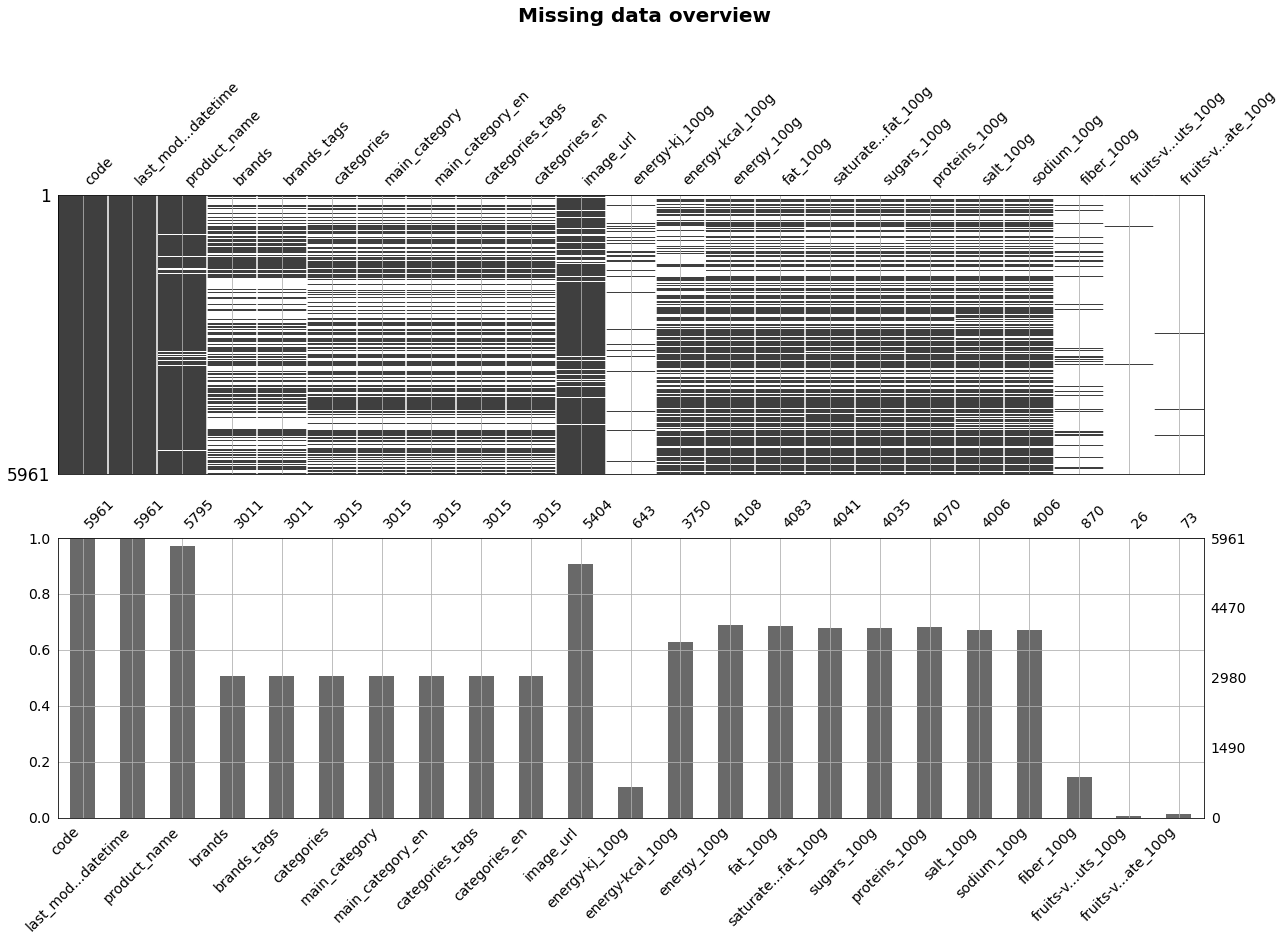

In [37]:
plot_missing_values(df_temp, 30)

<div class="alert alert-block alert-success">
<b>Analyzing products without a barcode</b><br>
After analyzing the products without barcode in Open Food Facts, we have decided to <b>keep them</b>,<br>because these records <b>can be found</b> through the name at the time of a <b>search</b> for a product by a user.    
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Processing the non-uniques codes</h3>
</div>

In [38]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  798009 rows and 23 columns
- Total of NaN values:            7489628
- Percentage of NaN:              40.81 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 105.7+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,798009,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],798009,696994,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,775020,528750,22989,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,image_url,object,720228,720158,77781,9.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,energy_100g,float32,623090,4545,174919,21.92,1178.382935,0.0,464.000,1100.000000,1674.000000,12200000.0,15538.601562
15,saturated-fat_100g,float32,620073,3684,177936,22.30,5.446947,0.0,0.200,2.000000,8.000000,21900.0,29.066158
16,sugars_100g,float32,619338,5341,178671,22.39,13.761168,-1.0,0.600,3.500000,19.985256,6880.0,21.925907
17,proteins_100g,float32,618992,4101,179017,22.43,9.138214,0.0,1.500,6.200000,12.900000,173000.0,220.102295
14,fat_100g,float32,617113,4941,180896,22.67,14.309522,0.0,1.000,8.000000,22.000000,91200.0,117.423164
18,salt_100g,float32,603563,6284,194446,24.37,1.310894,0.0,0.060,0.510000,1.300000,25000.0,32.950630


<div class="alert alert-block alert-warning">
    Based on the function <b>df_analysis</b> result, we can see that there are some codes which are not unique so, it is necessary to work on them</br></br>
    
<b>The message</b><br>
<i>- The key(s): code is present multiple times in the dataframe.<br>
&nbsp;&nbsp;&nbsp;It CANNOT be used as a primary key."</i></br>
   
</br>To do this, we are going to make the following steps:
<ul style="list-style-type: square;">
    <li>Filter the dataset by non-unique <b>code</b></li>
    <li>Select most recent value based on year for each code considering the multiples columns</li>
    <li>Merge the dataset with the filtered information</li>
</ul>
</div>

In [39]:
df_temp = df_nutri_score[df_nutri_score.duplicated(subset=["code"], keep=False)].copy()
df_temp = df_temp.sort_values(["code", "last_modified_datetime"], ascending=True)

In [40]:
df_temp.head(5)

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
577581,246804,2019-06-01 09:59:11,"Salade Chou, Pomme, céleri",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,611.0,10.400000,1.2,10.400000,1.5,0.30,0.120,NaN,NaN,NaN
48759,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri",M&S,m-s,"Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",...,611.0,10.400000,1.2,10.400000,1.5,0.25,0.100,2.3,NaN,NaN
662890,315739,2019-07-23 18:22:59,Sandwich Jambon Fromage Sans Gluten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1063.0,12.700000,5.5,2.500000,10.7,1.20,0.480,NaN,NaN,NaN
63896,315739,2019-12-02 14:52:43,NaN,Marks And Spencer,marks-and-spencer,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",...,1060.0,12.700000,5.5,2.500000,10.7,1.30,0.520,3.8,NaN,NaN
780012,331470,2019-07-23 10:57:35,4 Gluten Free zesty lemon muffins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1703.0,17.799999,2.7,33.599998,4.0,0.33,0.132,NaN,NaN,NaN


In [41]:
df_temp = pd.DataFrame(df_temp).reset_index()

In [42]:
del df_temp["index"]
df_temp.head(5)

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
0,246804,2019-06-01 09:59:11,"Salade Chou, Pomme, céleri",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,611.0,10.400000,1.2,10.400000,1.5,0.30,0.120,NaN,NaN,NaN
1,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri",M&S,m-s,"Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",...,611.0,10.400000,1.2,10.400000,1.5,0.25,0.100,2.3,NaN,NaN
2,315739,2019-07-23 18:22:59,Sandwich Jambon Fromage Sans Gluten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1063.0,12.700000,5.5,2.500000,10.7,1.20,0.480,NaN,NaN,NaN
3,315739,2019-12-02 14:52:43,NaN,Marks And Spencer,marks-and-spencer,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",...,1060.0,12.700000,5.5,2.500000,10.7,1.30,0.520,3.8,NaN,NaN
4,331470,2019-07-23 10:57:35,4 Gluten Free zesty lemon muffins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1703.0,17.799999,2.7,33.599998,4.0,0.33,0.132,NaN,NaN,NaN


In [43]:
df_temp = df_temp.rename_axis(None, axis=1)

In [44]:
df_temp.head(5)

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
0,246804,2019-06-01 09:59:11,"Salade Chou, Pomme, céleri",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,611.0,10.400000,1.2,10.400000,1.5,0.30,0.120,NaN,NaN,NaN
1,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri",M&S,m-s,"Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",...,611.0,10.400000,1.2,10.400000,1.5,0.25,0.100,2.3,NaN,NaN
2,315739,2019-07-23 18:22:59,Sandwich Jambon Fromage Sans Gluten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1063.0,12.700000,5.5,2.500000,10.7,1.20,0.480,NaN,NaN,NaN
3,315739,2019-12-02 14:52:43,NaN,Marks And Spencer,marks-and-spencer,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",...,1060.0,12.700000,5.5,2.500000,10.7,1.30,0.520,3.8,NaN,NaN
4,331470,2019-07-23 10:57:35,4 Gluten Free zesty lemon muffins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1703.0,17.799999,2.7,33.599998,4.0,0.33,0.132,NaN,NaN,NaN


<div class="alert alert-block alert-info">
    Select most recent value based on year for each code considering the multiples columns
</div>

In [45]:
df_temp = df_temp.groupby("code", as_index=False).last()

In [46]:
df_temp.head(6)

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
0,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri",M&S,m-s,"Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",...,611.0,10.400000,1.200000,10.400000,1.5,0.25,0.100,2.3,NaN,NaN
1,315739,2019-12-02 14:52:43,Sandwich Jambon Fromage Sans Gluten,Marks And Spencer,marks-and-spencer,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",...,1060.0,12.700000,5.500000,2.500000,10.7,1.30,0.520,3.8,NaN,NaN
2,331470,2021-04-01 13:41:55,Muffins au citron,Marks & Spencer,marks-spencer,"Biscuits et gâteaux, Gâteaux, Muffins, Muffins...",fr:muffins-au-citron,fr:muffins-au-citron,"en:biscuits-and-cakes,en:cakes,en:muffins,en:f...","Biscuits and cakes,Cakes,Muffins,Fruit Muffins...",...,1703.0,17.799999,2.700000,33.599998,4.0,0.33,0.132,NaN,NaN,NaN
3,333214,2019-07-31 12:37:28,Belgium milk chocolate coated toffee popcorn,Casino,casino,"Produits de la mer, Produits à tartiner, Produ...",en:taramasalata,Taramasalata,"en:seafood,en:spreads,en:salted-spreads,en:tar...","Seafood,Spreads,Salted spreads,Taramasalata",...,2197.0,28.200001,16.700001,48.299999,6.1,1.05,0.420,0.0,NaN,NaN
4,352536,2019-09-15 14:15:32,Fab Flamingo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1477.0,1.300000,0.900000,54.299999,0.3,0.55,0.220,NaN,NaN,NaN
5,360616,2020-01-13 16:40:52,Green Thai curry & jasmin rice,Marks And Spencer,marks-and-spencer,NaN,NaN,NaN,NaN,NaN,...,623.0,6.200000,2.800000,2.600000,3.6,0.40,0.160,NaN,NaN,NaN


<div class="alert alert-block alert-info">
    Deleting the non-unique values from <b>Nutri-Score</b> dataset
</div>

In [47]:
df_temp.shape

(60, 23)

In [48]:
df_nutri_score.shape

(798009, 23)

In [49]:
df_nutri_score = df_nutri_score[~df_nutri_score["code"].isin(df_temp["code"])]

In [50]:
df_nutri_score.shape

(797889, 23)

<div class="alert alert-block alert-info">
    Concatenating the datasets to have <b>only unique</b> values by <b>code</b>
</div>

In [51]:
df_nutri_score = pd.concat([df_nutri_score, df_temp])

In [52]:
df_nutri_score.shape

(797949, 23)

In [53]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 23 columns
- Total of NaN values:            7488827
- Percentage of NaN:              40.8 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 105.7+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],797949,696938,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,774969,528723,22980,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,image_url,object,720220,720152,77729,9.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.000,1100.000000,1674.000000,12200000.0,15539.136719
15,saturated-fat_100g,float32,620031,3684,177918,22.30,5.447080,0.0,0.200,2.000000,8.000000,21900.0,29.067114
16,sugars_100g,float32,619296,5341,178653,22.39,13.760906,-1.0,0.600,3.500000,19.950001,6880.0,21.926207
17,proteins_100g,float32,618950,4101,178999,22.43,9.138597,0.0,1.500,6.200000,12.900000,173000.0,220.109772
14,fat_100g,float32,617071,4941,180878,22.67,14.309892,0.0,1.000,8.000000,22.000000,91200.0,117.427109
18,salt_100g,float32,603523,6284,194426,24.37,1.310912,0.0,0.060,0.510000,1.300000,25000.0,32.951717


<div class="alert alert-block alert-success">
    At this point, we have combined the product non-uniques with <b>the plus recent data</b> deleting 60 records
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.3. Analyzing the missing values in Energy field</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
		<td align="center">Yes</td>
        <td align="left">
            energy-kj_100g<br>
            energy-kcal_100g<br>
            energy_100g</td>
        <td align="left">
            The fields energy-kj_100g and energy_100g seem to be the same value.<br>
            Consider the measure units to work with the values.
        </td>
 	</tr>
</table>

In [54]:
df_analysis(df_nutri_score[["code", "energy_100g", "energy-kcal_100g", "energy-kj_100g"]], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 4 columns
- Total of NaN values:            1103419
- Percentage of NaN:              34.57 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 37.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.0,1100.0,1674.0,12200000.0,15539.136719
2,energy-kcal_100g,float32,595481,5536,202468,25.37,283.296692,0.0,111.0,265.0,402.0,2910000.0,3785.686768
3,energy-kj_100g,float32,71900,3608,726049,90.99,1103.704102,0.0,435.0,977.0,1610.0,1094259.0,4161.389160


<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [55]:
VALUES_TEMP = [
    "3017620422003", "3033710065967", "3229820100234"
]

In [56]:
df_nutri_score[df_nutri_score["code"].isin(VALUES_TEMP)]

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
629040,3017620422003,2021-04-24 16:51:44,Nutella,"Ferrero,Nutella","ferrero,nutella","Produits à tartiner,Petit-déjeuners,Aides culi...",en:sugary-cooking-helpers,Sugary cooking helpers,"en:spreads,en:breakfasts,en:cooking-helpers,en...","Spreads,Breakfasts,Cooking helpers,Sweet sprea...",...,2252.0,30.9,10.6,56.299999,6.3,0.107,0.0428,NaN,NaN,NaN
637275,3033710065967,2021-03-02 09:38:08,Nesquik,Nestlé,nestle,"Boissons, Petit-déjeuners, Cacaos et chocolats...",en:chocolate-powders,Chocolate powders,"en:beverages,en:breakfasts,en:cocoa-and-its-pr...","Beverages,Breakfasts,Cocoa and its products,Co...",...,1591.0,3.0,1.5,75.000000,5.0,0.400,0.1600,6.5,NaN,NaN
688799,3229820100234,2021-03-27 15:25:14,Fourrés Chocolat noir,bjorg,bjorg,"Snacks, Snacks sucrés, Biscuits et gâteaux, Bi...",fr:biscuits-fourres-chocolat,fr:biscuits-fourres-chocolat,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...","Snacks,Sweet snacks,Biscuits and cakes,Biscuit...",...,2004.0,20.0,7.0,27.000000,7.1,0.500,0.2000,4.8,NaN,NaN


<div class="alert alert-block alert-info">
The <b>energy_100g</b> and <b>energy-kj_100g</b> fields are the same but it is necessary to compare in details these columns</br>
Let's compare the fields considering the <b>energy-kj_100g</b> as main field because it has <b>fewer data</b> than The <b>energy_100g</b> field
<ul style="list-style-type: square;">
    <li><b>energy_100g</b> has 623047 values</li>
    <li><b>energy-kj_100g</b> has 71900 values</li>
</ul>
</div>

In [57]:
df_temp = df_nutri_score[df_nutri_score["energy-kj_100g"].notnull()]

In [58]:
df_temp = pd.DataFrame(df_temp[["code", "energy_100g", "energy-kj_100g"]])

<div class="alert alert-block alert-info">
Now, let's compare <b>energy_100g</b> with <b>energy-kcal_100g</b> 
</div>

In [59]:
df_temp["comparison_column"] = np.where(df_temp["energy_100g"] == df_temp["energy-kj_100g"], True, False)

In [60]:
print("Amount of rows with differentes data between \"energy_100g\" and \"energy-kj_100g\" is:",
        df_temp[df_temp["comparison_column"] == False].shape[0]
)

Amount of rows with differentes data between "energy_100g" and "energy-kj_100g" is: 4


<div class="alert alert-block alert-success">
At this point, we got that there are only 4 rows with different data between <b>energy_100g</b> and <b>energy-kj_100g</b> fields so,</br> we can proceed to delete the <b>energy-kj_100g</b> field because the error could be minimum
</div>

In [61]:
del df_nutri_score["energy-kj_100g"]

In [62]:
df_analysis(df_nutri_score[["code", "energy_100g", "energy-kcal_100g"]], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            377370
- Percentage of NaN:              15.76 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.0,1100.0,1674.0,12200000.0,15539.136719
2,energy-kcal_100g,float32,595481,5536,202468,25.37,283.296692,0.0,111.0,265.0,402.0,2910000.0,3785.686768


<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [63]:
VALUES_TEMP = [
    "3017620422003", "3033710065967", "3229820100234"
]

In [64]:
df_nutri_score[df_nutri_score["code"].isin(VALUES_TEMP)]

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
629040,3017620422003,2021-04-24 16:51:44,Nutella,"Ferrero,Nutella","ferrero,nutella","Produits à tartiner,Petit-déjeuners,Aides culi...",en:sugary-cooking-helpers,Sugary cooking helpers,"en:spreads,en:breakfasts,en:cooking-helpers,en...","Spreads,Breakfasts,Cooking helpers,Sweet sprea...",...,2252.0,30.9,10.6,56.299999,6.3,0.107,0.0428,NaN,NaN,NaN
637275,3033710065967,2021-03-02 09:38:08,Nesquik,Nestlé,nestle,"Boissons, Petit-déjeuners, Cacaos et chocolats...",en:chocolate-powders,Chocolate powders,"en:beverages,en:breakfasts,en:cocoa-and-its-pr...","Beverages,Breakfasts,Cocoa and its products,Co...",...,1591.0,3.0,1.5,75.000000,5.0,0.400,0.1600,6.5,NaN,NaN
688799,3229820100234,2021-03-27 15:25:14,Fourrés Chocolat noir,bjorg,bjorg,"Snacks, Snacks sucrés, Biscuits et gâteaux, Bi...",fr:biscuits-fourres-chocolat,fr:biscuits-fourres-chocolat,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...","Snacks,Sweet snacks,Biscuits and cakes,Biscuit...",...,2004.0,20.0,7.0,27.000000,7.1,0.500,0.2000,4.8,NaN,NaN


<div class="alert alert-block alert-info">
As you know, at this point we have deleted <b>energy-kj_100g</b> field beacuse it is the same as <b>energy_100g</b><br><br>

On the other hand, we know the following:
<ul style="list-style-type: square;">
    <li>1 kcal = 4,1868 kJ</li>
    <li>1 kJ = 0,2388 kcal</li>
</ul>

So, we can try to complete the <b>energy_100g</b> field with values of <b>energy-kcal_100g</b> field after the respective unit of measure conversion
    
First of all, let's check whether there is some <b>energy_100g</b> values that we can complete with <b>energy-kj_100g</b> values
</div>

In [65]:
print("Amount of \"energy_100g\" to complete with \"energy-kcal_100g\" is:",
        df_nutri_score[(df_nutri_score["energy_100g"].isna()) & (df_nutri_score["energy-kcal_100g"].notnull())].shape[0]
)

Amount of "energy_100g" to complete with "energy-kcal_100g" is: 0


<div class="alert alert-block alert-success">
    There is not some <b>energy_100g</b> values that we can complete with <b>energy-kcal_100g</b> values so,</br> we can proceed to delete the <b>energy-kcal_100g</b> field
</div>

In [66]:
del df_nutri_score["energy-kcal_100g"]

In [67]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 21 columns
- Total of NaN values:            6560310
- Percentage of NaN:              39.15 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 115.7+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],797949,696938,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,774969,528723,22980,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,image_url,object,720220,720152,77729,9.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.000,1100.000000,1674.000000,12200000.0,15539.136719
13,saturated-fat_100g,float32,620031,3684,177918,22.30,5.447080,0.0,0.200,2.000000,8.000000,21900.0,29.067114
14,sugars_100g,float32,619296,5341,178653,22.39,13.760906,-1.0,0.600,3.500000,19.950001,6880.0,21.926207
15,proteins_100g,float32,618950,4101,178999,22.43,9.138597,0.0,1.500,6.200000,12.900000,173000.0,220.109772
12,fat_100g,float32,617071,4941,180878,22.67,14.309892,0.0,1.000,8.000000,22.000000,91200.0,117.427109
16,salt_100g,float32,603523,6284,194426,24.37,1.310912,0.0,0.060,0.510000,1.300000,25000.0,32.951717


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.4. Analyzing the missing values in Salt / Sodium</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Salt / Sodium</td>
		<td align="center">Yes</td>
        <td align="left">
            salt_100g<br>
            sodium_100g</td>
        <td align="left">Consider the measure units to work with the values.</td>
 	</tr>
</table>

In [68]:
df_analysis(df_nutri_score[["code", "salt_100g", "sodium_100g"]], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            388853
- Percentage of NaN:              16.24 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,salt_100g,float32,603523,6284,194426,24.37,1.310912,0.0,0.060,0.510,1.30,25000.0,32.951717
2,sodium_100g,float32,603522,6681,194427,24.37,0.524468,0.0,0.024,0.204,0.52,10000.0,13.180746


In [69]:
print("Amount of \"salt_100g\" to complete with \"energy-sodium_100g\" is:",
        df_nutri_score[(df_nutri_score["salt_100g"].isna()) & (df_nutri_score["sodium_100g"].notnull())].shape[0]
)

Amount of "salt_100g" to complete with "energy-sodium_100g" is: 0


<div class="alert alert-block alert-success">
    Based on <b>df_analysis</b>, we can see that <b>salt_100g</b> and <b>sodium_100g</b> have the same amount of data so,<br>
    we can proceed to delete one of them. In this case, we are going to delete <b>sodium_100g</b>
</div>

In [70]:
del df_nutri_score["sodium_100g"]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.5. Analyzing the missing values in Fruits, vegetables, legumes,nuts, rapeseed, walnut and olive oils</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
		<td align="center">Yes</td>
        <td align="left">
            fruits-vegetables-nuts_100g<br>
            fruits-vegetables-nuts-estimate_100g
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

In [71]:
VALUES_TEMP = [
    "code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [72]:
df_analysis(df_nutri_score[VALUES_TEMP], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            1579110
- Percentage of NaN:              65.97 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fruits-vegetables-nuts-estimate_100g,float32,10488,824,787461,98.69,46.186382,0.0,17.00,50.000000,64.0,100.0,28.991516
1,fruits-vegetables-nuts_100g,float32,6300,1086,791649,99.21,39.357761,0.0,4.09,30.630001,65.0,100.0,36.253693


In [73]:
df_temp = df_nutri_score[["code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"]]

<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [74]:
VALUES_TEMP = [
    "8076809513722", "8076809545396", "8076809513388"
]

In [75]:
df_nutri_score[df_nutri_score["code"].isin(VALUES_TEMP)]

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,image_url,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
1508404,8076809513388,2021-04-24 19:37:58,Barilla sauce tomates arrabbiata,Barilla,barilla,"Epicerie, Sauces, Sauces pour pâtes, Sauces to...",en:pimented-tomato-sauces,Pimented tomato sauces,"en:groceries,en:sauces,en:pasta-sauces,en:toma...","Groceries,Sauces,Pasta sauces,Tomato sauces,Ar...",https://static.openfoodfacts.org/images/produc...,250.0,3.1,0.3,5.0,1.4,1.00,2.2,90.000000,89.000000
1508415,8076809513722,2021-04-03 06:43:34,Barilla sauce tomates basilic,Barilla,barilla,"Epicerie, Sauces, Sauces tomate, Sauces tomate...",en:food,Food,"en:groceries,en:sauces,en:tomato-sauces,en:tom...","Groceries,Sauces,Tomato sauces,Tomato sauces w...",https://static.openfoodfacts.org/images/produc...,268.0,2.6,0.3,5.9,1.6,0.90,1.9,88.000000,86.800003
1508755,8076809545396,2021-04-22 04:30:14,Pesti con Basilico e Rucola,Barilla,barilla,"Lebensmittel, Saucen, Nudelsoßen, Pestos, Pest...",en:green-pestos,Green pestos,"en:groceries,en:sauces,en:pasta-sauces,en:pest...","Groceries,Sauces,Pasta sauces,Pestos,Green pestos",https://static.openfoodfacts.org/images/produc...,1828.0,42.5,5.0,5.0,3.9,1.24,2.0,35.400002,NaN


<div class="alert alert-block alert-info">
    Based on the function <b>df_analysis</b> we can see that there are almost 100% of missing-values for the three columns.<br><br>
    At the same time and based on <b>https://fr.openfoodfacts.org/</b> who says that the field <b>fruits-vegetables-nuts-estimate_100g</b> is a manual estimation<br> with the list of ingredients so, we can say that the most important field is <b>fruits-vegetables-nuts_100g</b>.<br><br>
    Due to that, we can try to complete the field <b>fruits-vegetables-nuts_100g</b> with values of <b>fruits-vegetables-nuts-estimate_100g</b>
</div>

In [76]:
print("Amount of \"fruits-vegetables-nuts_100g\" to complete with \"fruits-vegetables-nuts-estimate_100g\" is:",
        df_nutri_score[(df_nutri_score["fruits-vegetables-nuts_100g"].isna()) & (df_nutri_score["fruits-vegetables-nuts-estimate_100g"].notnull())].shape[0]
)

Amount of "fruits-vegetables-nuts_100g" to complete with "fruits-vegetables-nuts-estimate_100g" is: 10280


<div class="alert alert-block alert-info">
    The column <b>fruits-vegetables-nuts-estimate_100g</b> has 10280 records  that can use to complete the information in the column <b>fruits-vegetables-nuts_100g</b>.<br>
    So, let's try to use them. 
</div>

In [77]:
df_nutri_score["fruits-vegetables-nuts_100g"].fillna(df_nutri_score["fruits-vegetables-nuts-estimate_100g"], inplace=True)

In [78]:
print("Amount of \"fruits-vegetables-nuts_100g\" to complete with \"fruits-vegetables-nuts-estimate_100g\" is:",
        df_nutri_score[(df_nutri_score["fruits-vegetables-nuts_100g"].isna()) & (df_nutri_score["fruits-vegetables-nuts-estimate_100g"].notnull())].shape[0]
)

Amount of "fruits-vegetables-nuts_100g" to complete with "fruits-vegetables-nuts-estimate_100g" is: 0


In [79]:
VALUES_TEMP = [
    "code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [80]:
df_analysis(df_nutri_score[VALUES_TEMP], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            1568830
- Percentage of NaN:              65.54 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fruits-vegetables-nuts_100g,float32,16580,1465,781369,97.92,43.616482,0.0,12.0,48.614998,64.099998,100.0,32.062748
2,fruits-vegetables-nuts-estimate_100g,float32,10488,824,787461,98.69,46.186382,0.0,17.0,50.000000,64.000000,100.0,28.991516


<div class="alert alert-block alert-success">
    At this point, we have completed the information with the data contains in both column.<br>
    Now, we can delete the columns <b>fruits-vegetables-nuts-estimate_100g</b>
</div>

In [81]:
del df_nutri_score["fruits-vegetables-nuts-estimate_100g"]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.6. Analyzing the categories fields</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">App/Basic field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Category</td>
		<td align="center">No</td>
        <td align="left">
            categories<br>
            main_category<br>
            main_category_en<br>
            categories_tags<br>
            categories_en
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

In [82]:
VALUES_TEMP = [
    "code", "categories", "main_category", "main_category_en", "categories_tags", "categories_en"
]

In [83]:
df_analysis(df_nutri_score[VALUES_TEMP], "df_nutri_score", "code")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 6 columns
- Total of NaN values:            2192595
- Percentage of NaN:              45.8 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 50.6+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,797949,0,0.00
1,categories,category,359430,438519,54.96
2,main_category,category,359430,438519,54.96
3,main_category_en,category,359430,438519,54.96
4,categories_tags,category,359430,438519,54.96
5,categories_en,category,359430,438519,54.96


In [84]:
VALUES_TEMP = [
    "8076809513722", "8076809545396", "8076809513388"
]

In [85]:
df_temp = pd.DataFrame(df_nutri_score[["code", "product_name", "categories", "main_category", "main_category_en", "categories_tags", "categories_en"]])

In [86]:
pd.set_option("max_colwidth", None)
df_temp[df_temp["code"].isin(VALUES_TEMP)]

,code,product_name,categories,main_category,main_category_en,categories_tags,categories_en
1508404,8076809513388,Barilla sauce tomates arrabbiata,"Epicerie, Sauces, Sauces pour pâtes, Sauces tomate, Sauces Arrabiata, Sauces tomates pimentées",en:pimented-tomato-sauces,Pimented tomato sauces,"en:groceries,en:sauces,en:pasta-sauces,en:tomato-sauces,en:arrabbiata-sauces,en:pimented-tomato-sauces","Groceries,Sauces,Pasta sauces,Tomato sauces,Arrabbiata sauces,Pimented tomato sauces"
1508415,8076809513722,Barilla sauce tomates basilic,"Epicerie, Sauces, Sauces tomate, Sauces tomates au basilic, en:food",en:food,Food,"en:groceries,en:sauces,en:tomato-sauces,en:tomato-sauces-with-basil,en:food","Groceries,Sauces,Tomato sauces,Tomato sauces with basil,Food"
1508755,8076809545396,Pesti con Basilico e Rucola,"Lebensmittel, Saucen, Nudelsoßen, Pestos, Pesto alla Genovese",en:green-pestos,Green pestos,"en:groceries,en:sauces,en:pasta-sauces,en:pestos,en:green-pestos","Groceries,Sauces,Pasta sauces,Pestos,Green pestos"


In [87]:
pd.reset_option("display.max_colwidth") # reset width of showing cols

<div class="alert alert-block alert-info">
    Comparing <b>main_category</b> against <b>main_category_en</b>
</div>

In [88]:
print("Amount of \"main_category\" to complete with \"main_category_en\" is:",
        df_temp[(df_temp["main_category"].isna()) & (df_nutri_score["main_category_en"].notnull())].shape[0]
)

Amount of "main_category" to complete with "main_category_en" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories_en</b> against <b>categories_tags</b>
</div>

In [89]:
print("Amount of \"categories_en\" to complete with \"categories_tags\" is:",
        df_temp[(df_temp["categories_en"].isna()) & (df_nutri_score["categories_tags"].notnull())].shape[0]
)

Amount of "categories_en" to complete with "categories_tags" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories</b> against <b>main_category_en</b>
</div>

In [90]:
print("Amount of \"c\" to complete with \"main_category_en\" is:",
        df_temp[(df_temp["categories"].isna()) & (df_nutri_score["main_category_en"].notnull())].shape[0]
)

Amount of "c" to complete with "main_category_en" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories</b> against <b>categories_en</b>
</div>

In [91]:
print("Amount of \"categories\" to complete with \"categories_en\" is:",
        df_temp[(df_temp["categories"].isna()) & (df_nutri_score["categories_en"].notnull())].shape[0]
)

Amount of "categories" to complete with "categories_en" is: 0


<div class="alert alert-block alert-success">
    Based on <b>comparisons</b>, we can see that <b>categories</b> has the same amount of data that <b>categories_tags</b>, <b>main_category</b>, <b>main_category_en</b>, <b>categories_en</b> so,<br> we can proceed to delete all of them, except <b>categories</b>.
</div>

In [92]:
df_nutri_score.drop(["categories_en", "categories_tags", "main_category", "main_category_en"], axis=1, inplace=True)

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.6.1 Parsing treating missing values with groupby category</h4>
</div>

<div class="alert alert-block alert-info">
    Parsing treating missing values with <b>groupby category</b>
</div>

In [93]:
df_subset = df_nutri_score[df_nutri_score["categories"].notnull()]

In [94]:
df_analysis(df_subset, "df_subset", "code", flag="complete")


Analysis of df_subset dataset
--------------------------------------------------------------------
- Dataset shape:                  359430 rows and 15 columns
- Total of NaN values:            1131300
- Percentage of NaN:              20.98 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 41.8+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,359430,359430,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],359430,303270,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,categories,category,359430,52610,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,357404,237068,2026,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,image_url,object,338584,338558,20846,5.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,energy_100g,float32,302716,4140,56714,15.78,1193.430176,0.0,458.00,1055.00,1669.0,12200000.0,22276.787109
11,proteins_100g,float32,301503,2702,57927,16.12,9.177840,0.0,1.40,6.10,12.7,173000.0,315.179016
8,fat_100g,float32,300905,3275,58525,16.28,15.206133,0.0,1.00,8.00,23.0,91200.0,167.303528
10,sugars_100g,float32,300791,3507,58639,16.31,13.073586,-1.0,0.60,3.20,17.0,6880.0,23.196825
9,saturated-fat_100g,float32,300503,2598,58927,16.39,5.736265,0.0,0.20,2.00,8.3,21900.0,40.849060


<div class="alert alert-block alert-success">
    After analyzing a <b>subset</b> where there are <b>not missing values</b> in the column <b>categories</b>, based on the function <b>df_analysis</b> we got the following facts:
    
    <ul style="list-style-type: square;">
        <li>Only <b>two columns</b> are above <b>25% of missing values</b></li>
        <ul style="list-style-type: circle;">
            <li>The column <b>fiber_100g</b> has almost 70% of missing values</li>
            <li>As with the full dataset, the column <b>fruits-vegetables-nuts_100g</b> is above 95.55% of missing values</li>
        </ul>
    </ul>
    
    As a conclustion, we can use the <b>groupby categories</b> to treat missing values
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.7. Analyzing the brands fields</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">App/Basic field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Brand</td>
		<td align="center">No</td>
        <td align="left">
            brands<br>
            brands_tags
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

<div class="alert alert-block alert-info">
    Analyzing whether there are rows where we can use the brand instead of category
</div>

In [95]:
df_nutri_score[(df_nutri_score["product_name"].notnull()) & (df_nutri_score["brands"].notnull()) & (df_nutri_score["categories"].isna())].head(5)

,code,last_modified_datetime,product_name,brands,brands_tags,categories,image_url,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits-vegetables-nuts_100g
21,000000000114,2021-01-06 15:00:29,Chocolate n 3,Jeff de Bruges,jeff-de-bruges,NaN,https://static.openfoodfacts.org/images/produc...,10205.0,44.0,28.0,27.0,2.1,0.025,NaN,NaN
23,0000000001199,2018-10-27 21:08:31,Solène céréales poulet,CROUS,crous,NaN,https://static.openfoodfacts.org/images/produc...,916.0,5.9,0.5,1.7,9.7,0.464,2.8,NaN
31,0000000001663,2017-10-31 19:27:33,Crème dessert chocolat,Ferme De La Frémondière,ferme-de-la-fremondiere,NaN,https://static.openfoodfacts.org/images/produc...,0.0,0.0,0.0,0.0,0.0,0.000,NaN,NaN
39,0000000002264,2019-02-14 21:41:57,Baguette Poitevin,Crous resto,crous-resto,NaN,https://static.openfoodfacts.org/images/produc...,866.0,6.7,3.8,0.6,8.9,0.400,1.7,NaN
44,0000000003087,2016-09-17 09:18:13,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
print("Amount of \"brands\" to complete with \"energy-brands_tags\" is:",
        df_nutri_score[(df_nutri_score["brands"].isna()) & (df_nutri_score["brands_tags"].notnull())].shape[0]
)

Amount of "brands" to complete with "energy-brands_tags" is: 10


<div class="alert alert-block alert-success">
    At this point, we got that there are only 4 rows with different data between <b>brands_tags</b> and <b>brands</b> fields so,</br> we can proceed to delete the <b>brands</b> and <b>brands_tags</b> fields because the error could be minimum
</div>

In [97]:
df_nutri_score.drop(["brands", "brands_tags"], axis=1, inplace=True)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Treating missing-values</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Deleting missing values based on hypothesis</h3>
</div>

<div class="alert alert-block alert-info">
    After analyzing <b>df_nutri_score</b> columns, we got the table below (dataframe) to work on it.<br>
    Now, it is time to <b>treat</b> with <b>missing values</b> in our dataset
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Field</th>
        <th style="font-weight: bold;">Description</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">energy_100g</td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
 	</tr>
  	<tr>
		<td align="left">Salt</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">salt_100g</td>
 	</tr>
  	<tr>
		<td align="left">Fibers</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">fiber_100g</td>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes, nuts,<br>
            rapeseed, walnut and olive oils
        </td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">fruits-vegetables-nuts_100g</td>
 	</tr>
  	<tr>
		<td align="left">Code</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">code</td>
 	</tr>
    <tr>
		<td align="left">Last modified</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">last_modified_datetime</td>
 	</tr>
    <tr>
		<td align="left">Product name</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">product_name</td>
 	</tr>
    <tr>
		<td align="left">Category</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">categories</td>
 	</tr>
    <tr>
		<td align="left">Image</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">image_url</td>
 	</tr>
</table>

<div class="alert alert-block alert-info">
    Based on the function <b>df_analysis</b> we got the following facts:
    
    <ul style="list-style-type: square;">
        <li>There are almost <b>32%</b> of <b>missing values</b> in the <b>dataset</b></li>
        <li>Most of <b>columns</b> are above <b>20%</b> of <b>missing values</b></li>
        <li>There are <b>two columns</b> above <b>80%</b> of <b>missing values</b></li>
    </ul>
</div>

In [98]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 13 columns
- Total of NaN values:            3064686
- Percentage of NaN:              29.54 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 76.7+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],797949,696938,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,774969,528723,22980,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,image_url,object,720220,720152,77729,9.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.00,1100.000000,1674.000000,12200000.0,15539.136719
7,saturated-fat_100g,float32,620031,3684,177918,22.30,5.447080,0.0,0.20,2.000000,8.000000,21900.0,29.067114
8,sugars_100g,float32,619296,5341,178653,22.39,13.760906,-1.0,0.60,3.500000,19.950001,6880.0,21.926207
9,proteins_100g,float32,618950,4101,178999,22.43,9.138597,0.0,1.50,6.200000,12.900000,173000.0,220.109772
6,fat_100g,float32,617071,4941,180878,22.67,14.309892,0.0,1.00,8.000000,22.000000,91200.0,117.427109
10,salt_100g,float32,603523,6284,194426,24.37,1.310912,0.0,0.06,0.510000,1.300000,25000.0,32.951717


<div class="alert alert-block alert-warning">
    <b>Hypothesis</b>
    <ul style="list-style-type: square;">
        <li>All <b>rows</b> that <b>only</b> have <b>"code"</b> and <b>"last modified"</b> value are going to be <b>deleted</b> as they are considered input <b>errors</b></li>
    </ul>
    
</div>

In [99]:
COLUMNS_TO_CHECK = [
    "product_name", "categories", "image_url", "energy_100g", "fat_100g", 
    "saturated-fat_100g", "sugars_100g", "proteins_100g", "salt_100g", "fiber_100g", 
    "fruits-vegetables-nuts_100g"
]

In [100]:
df_nutri_score.shape

(797949, 13)

In [101]:
df_nutri_score.dropna(subset=COLUMNS_TO_CHECK, how="all", inplace=True)

In [102]:
df_nutri_score.shape

(789823, 13)

<div class="alert alert-block alert-success">
    <b>6328 rows</b> were <b>deleted</b> based on the above hypothesis
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. Imputation with mean considering groupby categories</h3>
</div>

In [103]:
df_nutri_score.head(3)

,code,last_modified_datetime,product_name,categories,image_url,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits-vegetables-nuts_100g
0,0000000000017,2019-06-25 11:55:18,Vitória crackers,NaN,https://static.openfoodfacts.org/images/produc...,1569.0,7.0,3.08,15.0,7.8,1.4,NaN,NaN
1,0000000000031,2018-10-13 21:06:57,Cacao,NaN,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000100,2015-10-12 14:13:32,moutarde au moût de raisin,"Epicerie, Condiments, Sauces, Moutardes",https://static.openfoodfacts.org/images/produc...,936.0,8.2,2.20,22.0,5.1,4.6,0.0,NaN


In [104]:
df_imputation = pd.DataFrame(df_nutri_score.copy()).reset_index(drop=True)

<div class="alert alert-block alert-info">
    Considering the column <b>categories</b> to treat the missing values
    <ul style="list-style-type: square;">
        <li>If the product <b>has a category</b> so, the mean to assign will be based on the mean of all products with the same category</li>
        <li>If the product <b>does not have a category</b> so, the mean to assign will be based on the mean of all products</li>
    </ul>
</div>

In [105]:
for col in df_imputation.columns:
    if df_imputation[col].dtypes == "float32":
        df_imputation.loc[df_imputation[col].isna() & df_imputation["categories"].notnull(), col] = df_imputation["categories"].map(df_imputation.groupby("categories")[col].mean())
        df_imputation[col].fillna(df_imputation[col].mean(), inplace=True)

In [106]:
df_analysis(df_imputation, "df_imputation", "code", flag="complete")


Analysis of df_imputation dataset
--------------------------------------------------------------------
- Dataset shape:                  789823 rows and 13 columns
- Total of NaN values:            514850
- Percentage of NaN:              5.01 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 53.9+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,789823,789823,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],789823,689836,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,energy_100g,float32,789823,8511,0,0.00,1155.083496,0.0,540.000000,1155.083618,1561.000000,12200000.0,13802.666016
6,fat_100g,float32,789823,8305,0,0.00,13.973887,0.0,1.600000,12.000000,18.400000,91200.0,103.872414
7,saturated-fat_100g,float32,789823,7013,0,0.00,5.316694,0.0,0.400000,3.020000,6.000000,21900.0,25.810844
8,sugars_100g,float32,789823,8712,0,0.00,13.668662,-1.0,0.900000,6.000000,13.668657,6880.0,20.056160
9,proteins_100g,float32,789823,7428,0,0.00,9.039044,0.0,2.200000,7.600000,11.000000,173000.0,194.863083
10,salt_100g,float32,789823,9869,0,0.00,1.312596,0.0,0.100000,0.800000,1.312595,25000.0,28.835915
11,fiber_100g,float32,789823,3787,0,0.00,2.401303,0.0,1.616667,2.401304,2.401304,1010.0,2.950886
12,fruits-vegetables-nuts_100g,float32,789823,2219,0,0.00,32.088036,0.0,32.088051,32.088051,32.088051,100.0,16.031744


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.3. Imputation with custom Imputer with scikit-learn</h3>
</div>

In [107]:
df_imputer = pd.DataFrame(df_nutri_score.copy()).reset_index(drop=True)

<div class="alert alert-block alert-info">
    After developing a custom imputer with scikit-learn considering groupby category.<br> At the same time, for a product that does not have a category, it will be assigned the mean of all product without category. 
</div>

In [108]:
imputer = GroupImputer(group_cols=["categories"], strategy="mean")

In [109]:
df_imputer = imp.fit_transform(df_imputer)

NameError: name 'imp' is not defined

In [ ]:
df_analysis(df_imputer, "df_imputer", "code", flag="complete")

In [ ]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")

<div class="alert alert-block alert-danger">
<b>Flag position</b>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.4. Imputation with KNNImputer</h3>
</div>

df_knn_imputer = pd.DataFrame(df_nutri_score.copy()).reset_index(drop=True)

<div class="alert alert-block alert-info">
    Making a <b>imputation</b> by 2 neighbors
</div>

impute_knn = KNNImputer(n_neighbors=2)

COLS_FLOAT = []
for col in df_knn_imputer.columns:
    if df_knn_imputer[col].dtypes == "float32":
        COLS_FLOAT.append(col)

In [ ]:
# df_knn_imputer[COLS_FLOAT] = impute_knn.fit_transform(df_knn_imputer[COLS_FLOAT])

In [ ]:
# df_sam.loc[df_sam["energy_100g"].isna() & df_sam["categories"].notnull(), "energy_100g"] = df_sam["categories"].map(df_sam.groupby("categories")["energy_100g"].mean())

In [ ]:
# df_nutri_score.columns[df_nutri_score.isna().sum()/df_nutri_score.shape[0] < 0.8]

In [ ]:
# sns.distplot(data['saturated-fat_100g'].head(10000).dropna())
# plt.show()
# sns.distplot(df_nutri_score['saturated-fat_100g'])

In [ ]:
# sns.boxplot(x=df_nutri_score['saturated-fat_100g'])

In [ ]:
# Histogramme
# df_nutri_score["energy_100g"].hist(density=True)
# plt.show()
# Histogramme plus beau
# df_simple_imputation_by_mean[df_simple_imputation_by_mean.energy_100g.abs() < 100]["energy_100g"].hist(density=True,bins=20)
# plt.show()

<div class="alert alert-block alert-danger">
<b>A considerar</b><br>
    - Valores aberrantes<br>
    - Histogramas
</div>

<div class="alert alert-block alert-warning">
<b>Analyzing products without a barcode</b><br>
After analyzing the products without barcode in Open Food Facts, we have decided to <b>keep them</b>, because these records <b>can be found</b> through the name at the time of a <b>search</b> for a product by a user.    
</div>